# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import cv2
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pickled data
import pickle

training_file = "./dataset/train.p"
validation_file= "./dataset/valid.p"
testing_file = "./dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

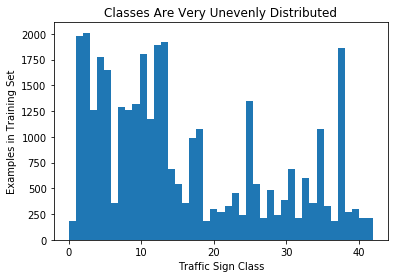

In [4]:
plt.hist(y_train, n_classes, histtype='bar')
plt.title("Classes Are Very Unevenly Distributed")
plt.xlabel("Traffic Sign Class")
plt.ylabel("Examples in Training Set")
plt.show()

In [5]:
import csv
class_labels = {}
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_labels = {key: val for key, val in reader}

In [6]:
def visualize_class(X_data, y_labels=[],
                    rows=1, cols=12, maxtitlelen=18, figsize=(15,2)):
    """
    Convenience method to visualize sets of images. If a set of corresponding
    class labels is passed, they will be printed along with the image.
    """
    has_labels = len(y_labels) > 0
    assert not has_labels or len(X_data) == len(y_labels)

    plt.figure(figsize=figsize)
    for i, img in enumerate(X_data):
        plt.subplot(rows, cols, i+1, xticks=[], yticks=[])
        plt.imshow(img, interpolation="nearest")
        if has_labels:
            y_val = y_labels[i]
            y_label = class_labels[str(y_val)][:maxtitlelen]
            plt.title("{}: {}".format(y_val, y_label), loc="left")
    plt.show()

In [ ]:
for cls in range(n_classes):
    print("=" * 95)
    print('LABEL: {} "{}"'.format(cls, class_labels[str(cls)]))
    print('COUNT: {}'.format(y_train[y_train==cls].shape[0]))
    class_xs = X_train[y_train==cls]
    visualize_class(class_xs[np.random.choice(class_xs.shape[0], size=12)])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [8]:
def preprocess(images):
    """
    1. Convert each image to grayscale and equalize histogram
    2. Normalize image values and set the mean to zero
    """
    out = np.empty(images.shape[:3], dtype=np.float32)
    for idx in range(out.shape[0]):
#         out[idx] = cv2.Laplacian(cv2.cvtColor(images[idx], cv2.COLOR_RGB2GRAY), cv2.CV_32F)
        out[idx] = cv2.equalizeHist(cv2.cvtColor(images[idx], cv2.COLOR_RGB2GRAY))
        out[idx] = cv2.normalize(out[idx], out[idx], alpha=-0.5, beta=0.5,
                                 norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return out.reshape(out.shape + (1,))

In [9]:
# preprocess data and copy y_labels to avoid shuffling original data during training
X_train_process, y_train_process = preprocess(X_train), np.copy(y_train)
X_valid_process, y_valid_process = preprocess(X_valid), np.copy(y_valid)
X_test_process, y_test_process = preprocess(X_test), np.copy(y_test)

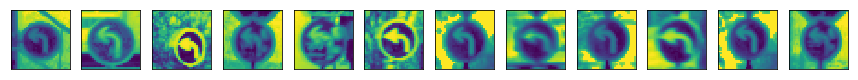

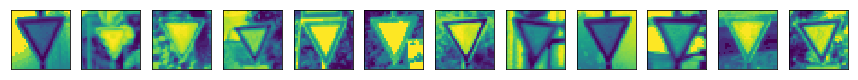

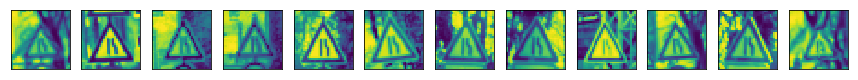

In [10]:
rand_indices = np.random.choice(n_classes, size=3)
for index in rand_indices:
    subset_process = X_train_process[y_train_process==index]
    subset_process = subset_process[np.random.choice(subset_process.shape[0], size=12)]
    visualize_class(subset_process.reshape(subset_process.shape[:3]))

### Model Architecture

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 100
BATCH_SIZE = 256

# Store layers weight & bias
weight_var = lambda w_shape: tf.Variable(tf.truncated_normal(w_shape, mean=0, stddev=0.1), name="weights")
bias_var = lambda n_vars: tf.Variable(tf.zeros(n_vars), name="biases")

def conv2d(layer, W, b, strides=1):
    out = tf.nn.conv2d(layer, W, strides=(1,strides,strides,1), padding="SAME")
    out = tf.nn.bias_add(out, b)
    return tf.nn.relu(out, name="relu")

def pool(layer, k=2):
    return tf.nn.max_pool(layer, ksize=(1,k,k,1), strides=(1,k,k,1), padding="SAME", name="pool")

def fully_connected(layer, W, b, activate=True):
    out = tf.add(tf.matmul(layer, W), b)
    if activate:
        out = tf.nn.relu(out, name="relu")
    return out

In [12]:
keep_prob = tf.placeholder(tf.float32)

def Model(X_inputs):
    # Layer 1: Convolutional. Input = 32x32x1.
    with tf.variable_scope("conv1"):
        conv1 = conv2d(X_inputs, weight_var((5,5,1,32)), bias_var(32)) # Output = 32x32x32.
        conv1 = pool(conv1, k=2) # Output = 16x16x32.

    # Layer 2: Convolutional.
    with tf.variable_scope("conv2"):
        conv2 = conv2d(conv1, weight_var((5,5,32,64)), bias_var(64)) # Output = 16x16x64.
        conv2 = pool(conv2, k=2) # Output = 8x8x64.
    
    # Layer 3: Convolutional.
    with tf.variable_scope("conv3"):
        conv3 = conv2d(conv2, weight_var((5,5,64,128)), bias_var(128)) # Output = 8x8x128.
        conv3 = pool(conv3, k=2) # Output = 4x4x128.

    # Layer 4: Flatten, Pool & Concatenate Layers.
    # TensorFlow v1.0.1: tf.concat(values, axis);
    with tf.variable_scope("flat"):
        try:
            flat = tf.concat((flatten(pool(conv1, k=4)),
                              flatten(pool(conv2, k=2)),
                              flatten(conv3)), 1) # Output 3584.
        # Prior TF versions: tf.concat(axis, values) :D
        except:
            flat = tf.concat(1, (flatten(pool(conv1, k=4)),
                              flatten(pool(conv2, k=2)),
                              flatten(conv3))) # Output 3584.
        flat = tf.nn.dropout(flat, keep_prob=keep_prob)

    # Layer 5: Fully Connected.
    with tf.variable_scope("fc1"):
        fc1 = fully_connected(flat, weight_var((3584,1024)), bias_var(1024)) # Output = 1024.
        fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # Layer 6: Fully Connected. Out.
    return fully_connected(fc1, weight_var((1024,43)), bias_var(43), activate=False) # Output = 43.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Features and Labels

In [13]:
X_vals = tf.placeholder(tf.float32, (None, 32, 32, 1))
y_vals = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y_vals, 43)

## Training Pipeline

In [14]:
initial_learn_rate = 0.001
global_step = tf.Variable(0, trainable=False)
decay_steps = 10
decay_rate = 0.75
learning_rate = tf.train.exponential_decay(initial_learn_rate, global_step,
                                           decay_steps, decay_rate, staircase=True)

logits = Model(X_vals)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
save_file = "./dataset/model.ckpt"
saver = tf.train.Saver()

def evaluate(X_data, y_labels):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_labels[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X_vals: batch_x, y_vals: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_process)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_process, y_train_process = shuffle(X_train_process, y_train_process)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_process[offset:end], y_train_process[offset:end]
            sess.run(training_operation, feed_dict={X_vals: batch_x, y_vals: batch_y, keep_prob: 0.50})
        validation_accuracy = evaluate(X_valid_process, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, save_file)
    print("Model saved")

## Evaluate the Model

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tf.train.Saver().restore(sess, save_file)
    test_accuracy = evaluate(X_test_process, y_test_process)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [32]:
sign_classes = np.array([7, 9, 11, 17, 25, 31, 40])
n_signs = len(sign_classes)
sign_data = np.empty((n_signs,32,32,3), dtype=np.uint8)
sign_path = "./signs/{}.jpg"

for i, label in enumerate(sign_classes):
    sign_data[i] = cv2.cvtColor(cv2.imread(sign_path.format(label), cv2.IMREAD_COLOR),
                                cv2.COLOR_BGR2RGB)
sign_data_process = preprocess(sign_data)

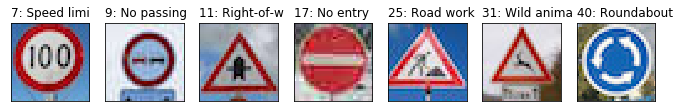

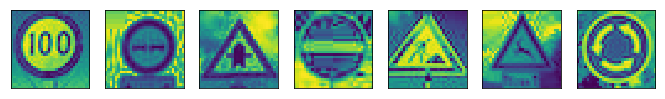

In [33]:
visualize_class(sign_data, sign_classes, maxtitlelen=10, figsize=(20, 2))
visualize_class(sign_data_process.reshape(sign_data_process.shape[:3]), figsize=(20, 2))

### Analyze Performance

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tf.train.Saver().restore(sess, save_file)
    new_img_accuracy = evaluate(sign_data_process, sign_classes)
    print("New Image Accuracy = {:.3f}".format(new_img_accuracy))

New Image Accuracy = 0.857


### Predict the Sign Type for Each Image

In [20]:
n_preds = 5
prediction_operation = tf.nn.top_k(tf.nn.softmax(logits), n_preds)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_file)
    probs, pred_classes = sess.run(prediction_operation,
                                   feed_dict={X_vals: sign_data_process, keep_prob: 1.})

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [21]:
def prediction_confidence(img, likelihoods, predictions):
    labels = ["{:.4f}% : {}".format(likelihoods[i]*100, class_labels[str(c)])
              for i, c in enumerate(predictions)]
    y_pos = np.arange(len(labels))

    plt.figure(figsize=(4,2))
    plt.subplot(121, xticks=[], yticks=[])
    plt.imshow(img)
    plt.subplot(122)
    plt.barh(y_pos, likelihoods)
    plt.yticks(y_pos, labels, position=(1.2,1), ha="left", weight="semibold")
    plt.show()

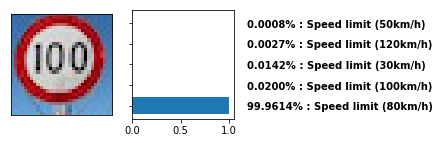

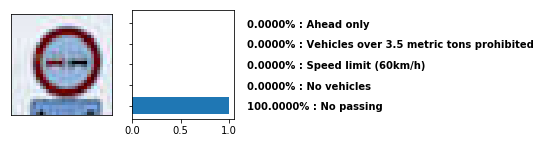

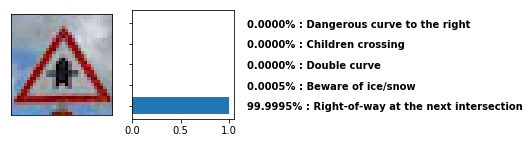

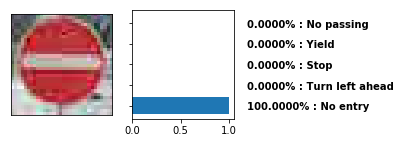

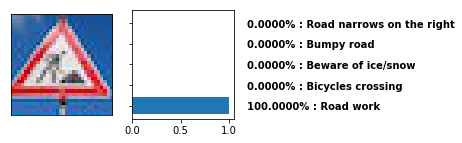

In [22]:
for idx in range(n_preds):
    prediction_confidence(sign_data[idx], probs[idx], pred_classes[idx])

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [60]:
def outputFeatureMap(session, image_input, tf_activation, rows=6, cols=8, figsize=(15,25), activation_min=-1, activation_max=-1 ,plt_num=1):
    """
    image_input:
        the test image being fed into the network to produce the feature maps
    tf_activation:
        should be a tf variable name used during your training procedure that
        represents the calculated state of a specific weight layer
    activation_min/max:
        can be used to view the activation contrast in more detail, by default
        matplot sets min and max to the actual min and max values of the output
    plt_num:
        used to plot out multiple different weight feature map sets on the same block,
        just extend the plt number for each new feature map entry
    """
    activation = tf_activation.eval(session=session)
    featuremaps = activation.shape[3]
    assert rows*cols >= featuremaps

    plt.figure(plt_num, figsize=figsize)
    for featuremap in range(featuremaps):
        plt.subplot(rows, cols, featuremap+1)
        plt.title('FM{}'.format(featuremap))
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest", vmin=activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest")

(5, 5, 32, 64)


ValueError: num must be 1 <= num <= 48, not 49

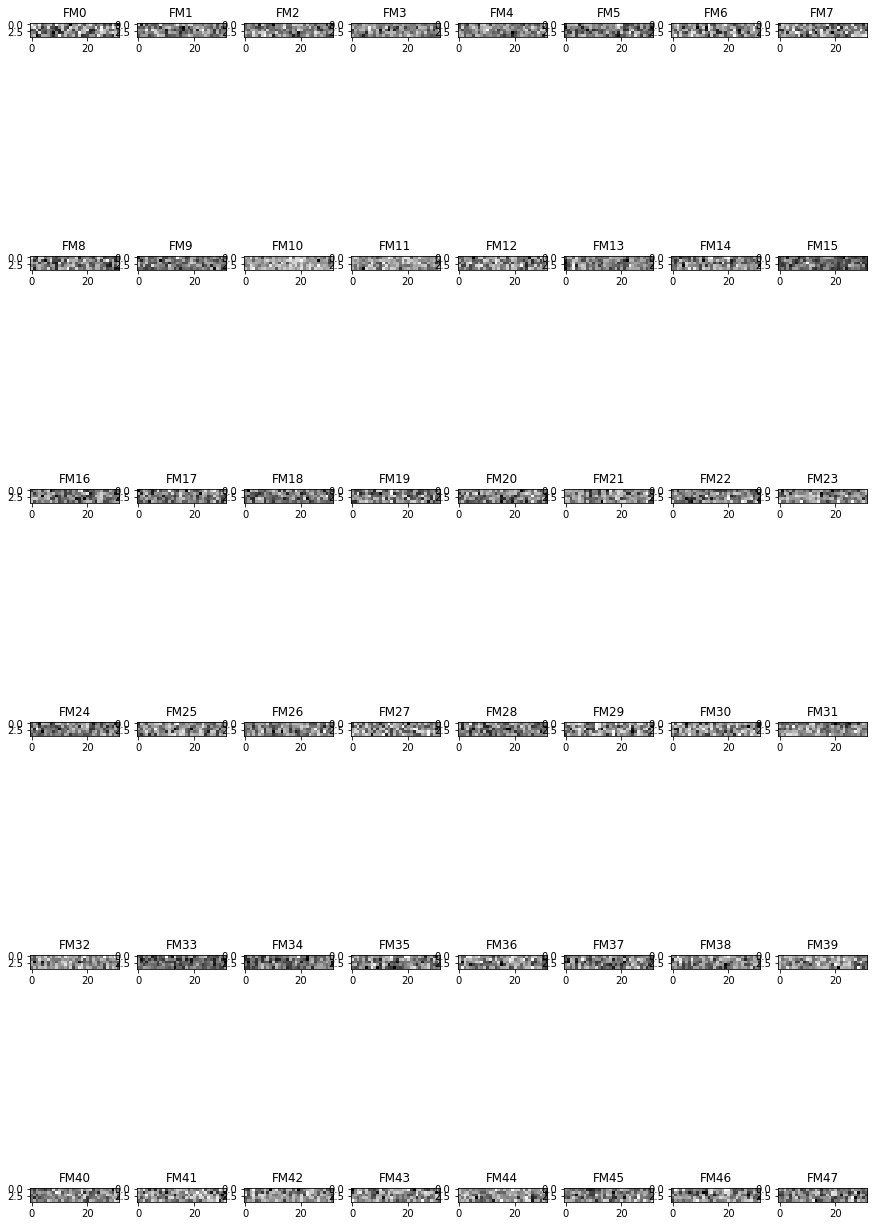

In [64]:
conv1_weights,_ = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="conv1")
conv2_weights,_ = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="conv2")
sign_img = sign_data_process[0]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_file)
#     outputFeatureMap(sign_img, conv1_weights)
    outputFeatureMap(sign_img, conv2_weights)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 